# TPE N°2 : Les expérimentations sur la fonction quadratique

## Noms et Matricules des membres


| MATRICULES  |           NOMS DES MEMBRES           |
|-------------|--------------------------------------|
|   22T2960   |           BELL ARSÈNE KEVIN          |
|   22W2147   |           MELONG LETHYCIA            |
|   22W2164   |       DASSI MANDJO LEA JUSTINE       |

Notre étude portera tout le long sur la Fonction de Himmelblau **f(x, y) = x² − y²**

Nous implémenterons la méthode de plus profonde descente pour minimiser **f(x, y) = x² − y²** et par la suite, nous analyserons des résultats obtenus.

In [45]:
import sympy

x,y = sympy.symbols('x y')
f = x**2 -  y**2 
grad_f=[sympy.diff(f,var) for var in (x,y)]
print("\nle gradient est :\n", grad_f)
points_critiques = sympy.solve(grad_f, (x, y))
print("\nles points critiques sont :\n", points_critiques)
hessienne = sympy.hessian(f, (x,y))
print("\nla hessienne est :")

hessienne



le gradient est :
 [2*x, -2*y]

les points critiques sont :
 {x: 0, y: 0}

la hessienne est :


Matrix([
[2,  0],
[0, -2]])

In [73]:

print("\nle determinant de la hessienne est :")
hessienne.det()


le determinant de la hessienne est :


-4

#### la hessienne a comme valeurs propres 2 et -2 ce qui fait qu'elle n'est pas definie positive et par consequant la fonction f(x, y) = X^2 - Y^2 n'est pas convexe et donc le point critique (0, 0) est un point selle de f

### 2) - Appliquons les algorithmes de gradient à pas fixe et à pas optimal sur la fonction f

Implémentons ces deux méthodes à partir du point x0 = (-1,2) et illustrons leurs comportements.

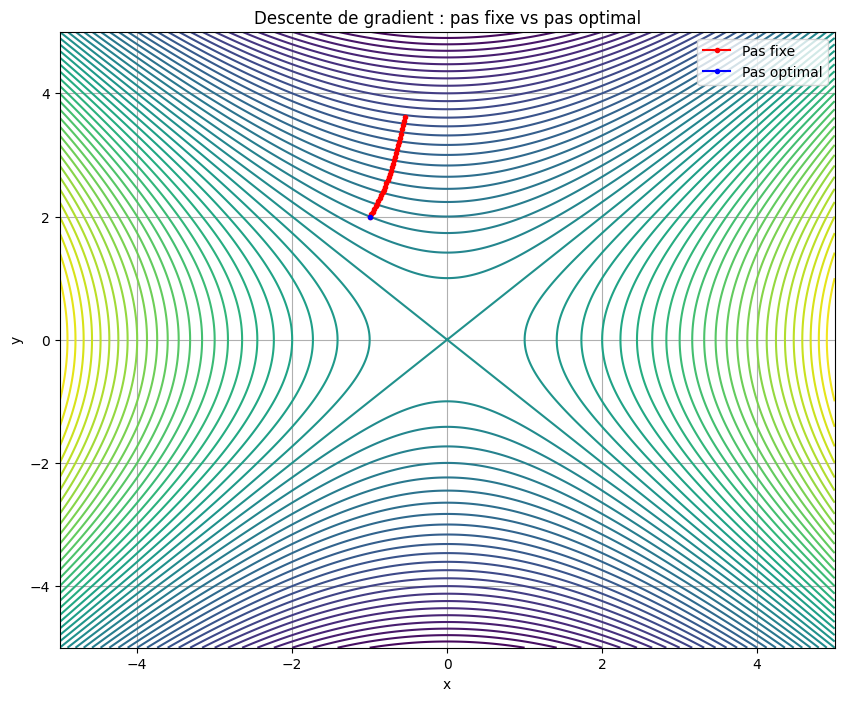

In [55]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

# ------------------------------
# 1. Définition symbolique
# ------------------------------
x, y, alpha = sp.symbols('x y alpha', real=True)

f = x**2 - y**2
grad_f = sp.Matrix([sp.diff(f, x), sp.diff(f, y)])

# Fonction numérique
f_num = sp.lambdify((x, y), f, "numpy")
grad_num = sp.lambdify((x, y), grad_f, "numpy")

# ------------------------------
# 2. Algorithmes
# ------------------------------

def gradient_pas_fixe(x0, step=0.01, n_iter=20):
    xk = np.array(x0, dtype=float)
    pts = [xk.copy()]
    for i in range(n_iter):
        g = np.array(grad_num(xk[0], xk[1]), dtype=float).flatten()
        xk = xk - step * g
        pts.append(xk.copy())
    return np.array(pts)


def gradient_pas_optimal(x0, n_iter=20):
    xk = np.array(x0, dtype=float)
    pts = [xk.copy()]
    for i in range(n_iter):
        g = np.array(grad_num(xk[0], xk[1]), dtype=float).flatten()

        # Ligne de recherche : f(xk - alpha*g)
        expr_alpha = f.subs({x: xk[0] - alpha*g[0],
                             y: xk[1] - alpha*g[1]})

        dphi = sp.diff(expr_alpha, alpha)
        sols = sp.solve(dphi)

        # garder alpha réel et positif
        alpha_vals = [float(s) for s in sols if s.is_real and float(s) > 0]

        if len(alpha_vals) == 0:
            break

        alpha_star = min(alpha_vals)

        xk = xk - alpha_star * g
        pts.append(xk.copy())

    return np.array(pts)


# ------------------------------
# 3. Exécution des méthodes
# ------------------------------
x0 = [-1, 2]   # point initial

pts_fixed = gradient_pas_fixe(x0, step=0.01, n_iter=30)
pts_opt = gradient_pas_optimal(x0, n_iter=15)

# ------------------------------
# 4. Tracé des lignes de niveau
# ------------------------------
X = np.linspace(-5, 5, 400)
Y = np.linspace(-5, 5, 400)
XX, YY = np.meshgrid(X, Y)
ZZ = f_num(XX, YY)

plt.figure(figsize=(10, 8))
plt.contour(XX, YY, ZZ, levels=50)
plt.title("Descente de gradient : pas fixe vs pas optimal")
plt.xlabel("x")
plt.ylabel("y")

# ------------------------------
# 5. Tracé des trajectoires
# ------------------------------
plt.plot(pts_fixed[:,0], pts_fixed[:,1], 'r.-', label="Pas fixe")
plt.plot(pts_opt[:,0], pts_opt[:,1], 'b.-', label="Pas optimal")

plt.legend()
plt.grid(True)
plt.show()


**Remarques :**

- En voulant conserver le pas représenté par α, en nombre positif et réel, on se rend compte que le point d'origine ne bouge pas parce que, pour la fonction quadratique, la dérivée de la fonction φ(α) = f(xₖ − α gₖ) le long de la direction du gradient n’a pas de solution positive à l’équation.
- la solution analytique α* n’existe pas, donc Sympy renvoie une liste vide.

Ainsi, On doit remplacer la résolution symbolique par une **minimisation numérique**. On utilisera alors **scipy.optimize**.

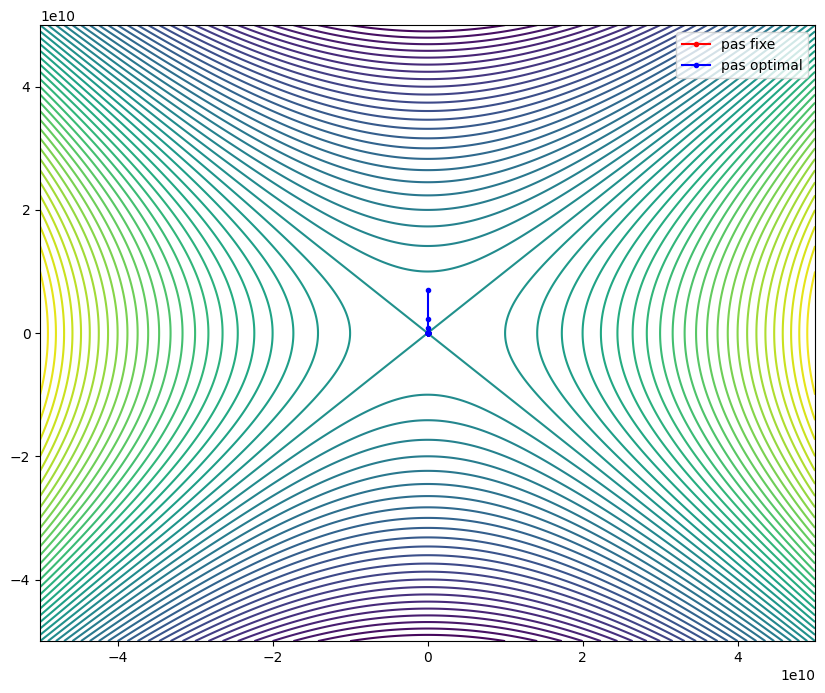

In [59]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# -----------------------------------------------
# 1. Himmelblau
# -----------------------------------------------
x, y = sp.symbols('x y')
f = x**2  - y**2
grad_f = sp.Matrix([sp.diff(f, x), sp.diff(f, y)])

f_num = sp.lambdify((x, y), f, "numpy")
grad_num = sp.lambdify((x, y), grad_f, "numpy")


# -----------------------------------------------
# 2. Descente à pas optimal NUMERIQUE
# -----------------------------------------------
def gradient_pas_optimal_numerique(x0, n_iter=20):
    xk = np.array(x0, float)
    pts = [xk.copy()]

    for _ in range(n_iter):
        g = np.array(grad_num(xk[0], xk[1])).flatten()

        # fonction φ(α) = f(xk - α g)
        phi = lambda a: f_num(xk[0] - a*g[0], xk[1] - a*g[1])

        # minimisation dans un intervalle raisonnable (line search)
        res = minimize_scalar(phi, bounds=(0, 1), method='bounded')

        alpha_star = res.x

        xk = xk - alpha_star * g
        pts.append(xk.copy())

    return np.array(pts)


# -----------------------------------------------
# 3. Descente à pas fixe
# -----------------------------------------------
def gradient_pas_fixe(x0, step=0.01, n_iter=40):
    xk = np.array(x0, float)
    pts = [xk.copy()]
    for _ in range(n_iter):
        g = np.array(grad_num(xk[0], xk[1])).flatten()
        xk = xk - step * g
        pts.append(xk.copy())
    return np.array(pts)


# -----------------------------------------------
# 4. Exécution
# -----------------------------------------------
x0 = [-1, 2]
pts_fixed = gradient_pas_fixe(x0)
pts_opt = gradient_pas_optimal_numerique(x0)

# -----------------------------------------------
# 5. Tracé
# -----------------------------------------------
X = np.linspace(-5*10e9, 5*10e9, 400)
Y = np.linspace(-5*10e9, 5*10e9, 400)
XX, YY = np.meshgrid(X, Y)
ZZ = f_num(XX, YY)

plt.figure(figsize=(10, 8))
plt.contour(XX, YY, ZZ, levels=50)
plt.plot(pts_fixed[:,0], pts_fixed[:,1], 'r.-', label="pas fixe")
plt.plot(pts_opt[:,0], pts_opt[:,1], 'b.-', label="pas optimal")
plt.legend()
plt.show()


**Remarques :**

- La méthode de descente de gradient à pas optimal s'avère etre extremement efficace car elle obtient plus rapidement le résultat. Elle semble l'obtenir en 2 itérations.
- La méthode de descente de gradient à pas fixe quant à elle, bien qu'elle permet d'atteindre le meme résultat est beaucoup plus lente que la méthode de plus profonde descente. Elle semble l'obtenir en plus de 11 itérations.

#### Analysons les nombres d'itérations de la méthode de plus profonde descente

In [60]:
import numpy as np
import sympy as sp
import pandas as pd
from scipy.optimize import minimize_scalar

# ------------------------------------------------------
# 1. Définition de la fonction de Himmelblau
# ------------------------------------------------------
x, y = sp.symbols('x y')
f = x**2 - y**2 
grad_f = sp.Matrix([sp.diff(f, x), sp.diff(f, y)])

f_num = sp.lambdify((x, y), f, "numpy")
grad_num = sp.lambdify((x, y), grad_f, "numpy")

# ------------------------------------------------------
# 2. Méthode de plus forte descente (pas optimal)
# ------------------------------------------------------
def gradient_descent_table(x0, n_iter=20):
    xk = np.array(x0, float)

    iterations = []

    for k in range(n_iter):
        fx = f_num(xk[0], xk[1])
        g = np.array(grad_num(xk[0], xk[1])).flatten()
        norm2g = np.dot(g, g)

        # Fonction φ(α) = f(xk - α g)
        phi = lambda a: f_num(xk[0] - a*g[0], xk[1] - a*g[1])

        # Pas optimal (line search)
        res = minimize_scalar(phi, bounds=(0, 1), method='bounded')
        alpha_star = res.x

        iterations.append([
            fx,                  # f(xk, yk)
            norm2g,              # norme du gradient au carré
            alpha_star,          # pas α
            xk[0],               # xk
            xk[1]                # yk
        ])

        # Mise à jour du point
        xk = xk - alpha_star * g

    df = pd.DataFrame(iterations, columns=[
         "f(xk,yk)", "norme2_grad", "alpha", "xk", "yk"
    ])
    
    return df

# ------------------------------------------------------
# 3. Exemple d'exécution
# ------------------------------------------------------
x0 = [-1, 2]
df = gradient_descent_table(x0, n_iter=20)

print(df)


        f(xk,yk)   norme2_grad     alpha        xk            yk
0  -3.000000e+00  2.000000e+01  0.999994 -1.000000  2.000000e+00
1  -3.499974e+01  1.479988e+02  0.999994  0.999988  5.999976e+00
2  -3.229949e+02  1.299979e+03  0.999994 -0.999976  1.799986e+01
3  -2.914931e+03  1.166772e+04  0.999994  0.999964  5.399936e+01
4  -2.624217e+04  1.049767e+05  0.999994 -0.999952  1.619974e+02
5  -2.361856e+05  9.447505e+05  0.999994  0.999940  4.859903e+02
6  -2.125662e+06  8.502655e+06  0.999994 -0.999928  1.457965e+03
7  -1.913081e+07  7.652325e+07  0.999994  0.999917  4.373878e+03
8  -1.721759e+08  6.887037e+08  0.999994 -0.999905  1.312158e+04
9  -1.549571e+09  6.198284e+09  0.999994  0.999893  3.936459e+04
10 -1.394603e+10  5.578412e+10  0.999994 -0.999881  1.180933e+05
11 -1.255133e+11  5.020531e+11  0.999994  0.999869  3.542785e+05
12 -1.129610e+12  4.518442e+12  0.999994 -0.999857  1.062831e+06
13 -1.016641e+13  4.066565e+13  0.999994  0.999845  3.188481e+06
14 -9.149699e+13  3.65988

Nous constatons qu'effectivement pour une précision eps = 10^-1; en deux itérations, le critère d'optimalité est satisfait. 

Pour une précision supérieure à eps = 10^-5, à partir de la deuxième itération on approche le plus possible le résultat et ce n'est qu'à la 18-19 ième itération que le résultat devient constant et que le critère d'optimalité soit satisfait. 

#### Analysons les nombres d'itérations de la méthode de gradient à pas fixe

In [74]:
import numpy as np
import pandas as pd
import sympy as sp


x, y = sp.symbols('x y')
f = x**2 - y**2 
grad_f = sp.Matrix([sp.diff(f, x), sp.diff(f, y)])

f_num = sp.lambdify((x, y), f, "numpy")
grad_num = sp.lambdify((x, y), grad_f, "numpy")


def iterations_pour_minimum(x0, alpha, tol=1e-5, max_iter=2000):
    xk = np.array(x0, float)
    for k in range(1, max_iter+1):
        g = np.array(grad_num(xk[0], xk[1])).flatten()
        if np.linalg.norm(g) < tol:
            return k  
        xk = xk - alpha * g
    return max_iter  


x0 = [-1.0, 2.0] 
alphas = np.linspace(0.00005, 0.005, 7)
alphas.sort() 
n = len(alphas)

# --- Calcul du nombre d'itérations pour chaque pas ---
iterations = [iterations_pour_minimum(x0, alpha) for alpha in alphas]

# --- Création du tableau ---
df = pd.DataFrame([alphas, iterations], index=['alpha', 'k'])
df.columns = [f'α{i+1}' for i in range(n)]

print(df)


               α1           α2         α3           α4          α5  \
alpha     0.00005     0.000875     0.0017     0.002525     0.00335   
k      2000.00000  2000.000000  2000.0000  2000.000000  2000.00000   

                α6        α7  
alpha     0.004175     0.005  
k      2000.000000  2000.000  
